# Projet Pricing 


La société XYZ vend un logiciel au prix de 39€. Le chiffre d’affaires ayant été stable pendant un certain temps, le mainteneur du produit (Product Owner PO) a donc décidé de lancer un test d’augmentation du prix du software. Il espère que cela augmenterait les revenus! Il lance un TEST, dans l'expérience, 66\% des utilisateurs ont remarqué le changement de prix (39€), alors qu'un échantillon aléatoire de 33\% n'a pas remarqué le prix plus élevé (59€).

Le test étant en cours depuis un certain temps et le PO, souhaite comprendre comment cela s'est passé et s’il serait judicieux d’augmenter le prix pour tous les utilisateurs.

En particulier, il vous a posé les questions suivantes:

* L'entreprise devrait-elle vendre son logiciel à 39 ou 59€?
* Le PO est intéressé par une vision globale du comportement des utilisateurs, en particulier en se concentrant sur des informations exploitables susceptibles d'augmenter le taux de conversion. Que faite vous avec ses données?
* **Bonus** : Le PO estime que le test dure trop longtemps et aurait dû pouvoir obtenir des résultats significatifs plus rapidement. Êtes-vous d'accord avec son intuition? 


## Objectifs 
Commme vous l'avez sans doute compris, l'objectif ici est d'évaluer si ce test de tarification a réussi ou pas. Par ailleurs, vous devez vous concentrer sur la segmentation des utilisateurs et ainsi fournir des informations sur les différent segments, ainsi que sur toute autre information pertinentes que vous pourriez trouver.

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2,f_classif
from sklearn.tree import DecisionTreeClassifier,export_graphviz

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

seed = 42

## Load des data

In [4]:
testdata = pd.read_csv("./data/test_results.csv",index_col="user_id")
testdata.rename(columns={'operative_system':'OS'},inplace=True)

In [4]:
testdata.head(5)

,timestamp,source,device,OS,test,price,converted
user_id,,,,,,,
604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


## Preprocessing & Explorations 

In [5]:
X = testdata.copy()
del X['timestamp']

src_label_encoder = LabelEncoder()
dev_label_encoder = LabelEncoder()
os_label_encoder = LabelEncoder()

X["source"] = src_label_encoder.fit_transform(testdata.source)
X["device"] = dev_label_encoder.fit_transform(testdata.device)
X["OS"] = os_label_encoder.fit_transform(testdata.OS)

In [6]:
X.head()

,source,device,OS,test,price,converted
user_id,,,,,,
604839,3,0,1,0,39,0
624057,8,0,0,0,39,0
317970,0,0,0,0,39,0
685636,5,0,1,1,59,0
820854,3,1,3,0,39,0


# Le test du $\chi^2$

Le test du $\chi^2$ est un test statistique qui permet de tester l'adéquation d'une série de données à une famille de lois de probabilité ou de tester l'indépendance entre deux variables aléatoires. Nous allons l'utiliser ici pour voir si nos variables explicatives influencent notre test.   

In [9]:
s = X['converted'].value_counts(normalize=True)
s

0    0.981667
1    0.018333
Name: converted, dtype: float64

In [8]:
colnames = ["source","device","OS"]
ch2values,pvalues = chi2(X.loc[:,colnames],X["test"])
pd.DataFrame({'chi2_value':ch2values,'pvalue':pvalues},index = colnames).sort_values(by='pvalue')

,chi2_value,pvalue
OS,83.085986,7.856065e-20
device,44.366335,2.723301e-11
source,0.924742,3.362329e-01


On voit que la division entre les groupes test & contrôle n'est pas aléatoire. Les variables OS et device ont potentiellement un impact plus important que la variable source. 

In [9]:
def calc_ratios(s):
    d = s.value_counts(normalize=True)
    d['total'] = s.shape[0]
    return d
test_ctrl_by_os = testdata.groupby('OS')['test'].apply(calc_ratios).unstack()
test_ctrl_by_os

,0,1,total
OS,,,
android,0.643358,0.356642,74935.0
iOS,0.647934,0.352066,95465.0
linux,0.533736,0.466264,4135.0
mac,0.652422,0.347578,25085.0
other,0.647865,0.352135,16204.0
windows,0.629764,0.370236,100976.0


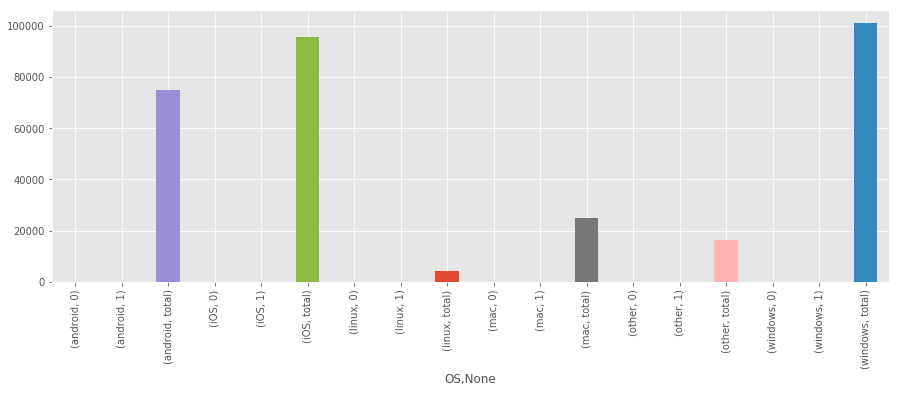

In [11]:
test_ctrl_by_os.plot(kind='bar',figsize=(15,5))

In [11]:
os_by_test_ctrl = testdata.groupby('test')['OS'].apply(lambda s: s.value_counts(normalize=False)).unstack()
#os_by_test_ctrl.loc[[1],"iOS"]
os_by_test_ctrl

,windows,iOS,android,mac,other,linux
test,,,,,,
0,63591,61855,48210,16366,10498,2207
1,37385,33610,26725,8719,5706,1928


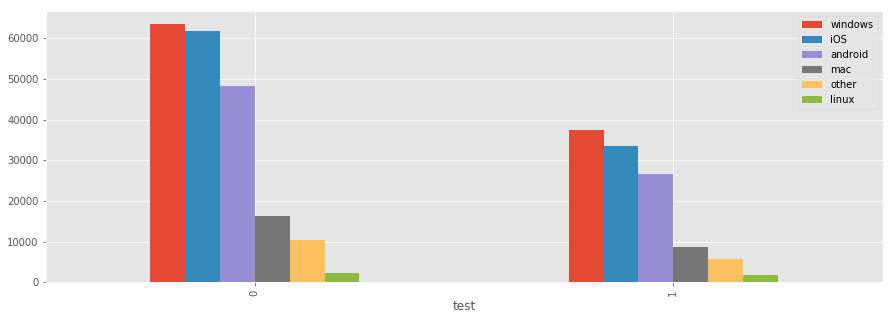

In [12]:
os_by_test_ctrl.plot(kind='bar',figsize=(15,5))

## 59 ou 39 ? 

In [16]:
revenues = testdata.groupby(by="test").apply(lambda df: df.price * df.converted)
ctrl_revenues = revenues[0]
test_revenues = revenues[1]

In [15]:
def group_statistics(df):
    return pd.Series({'n_users': df.shape[0],
                      'convert_rate': df.converted.mean(), 
                      'mean_revenue': (df.price * df.converted).mean()})
testdata.groupby('test').apply(group_statistics)

,n_users,convert_rate,mean_revenue
test,,,
0,202727.0,0.019904,0.776734
1,114073.0,0.015543,0.916843


Nous allons effectuer un test statistique pour vérifier si le revenu moyen du groupe de test est supérieur au revenu moyen du groupe de contrôle. On peut donc formuler deux hypothèses : 
* $H_0$: revenu moyen du groupe de test égal au revenu moyen du groupe témoin
* $H_A$: le revenu moyen du groupe de test est supérieur au revenu moyen du groupe de contrôle

In [16]:
ttest_result = ss.ttest_ind(test_revenues,ctrl_revenues,equal_var=False)
# ttest_ind is a two tailed
# since our HA is test_mean > ctrl_mean, so we need to divide by 2
ttest_result.pvalue/2 

7.703749302339191e-09

On voit que la p-value est très inférieure au seuil de $0.05$, on peut donc rejeter $H_0$ et donc considérer $H_A$, c'est-à-dire que le revenu moyen du groupe test est nettement supérieur au revenu moyen du groupe témoin.  

D'apres nos résultat nous ne pouvons malheuresement pas répondre directement à cette question il f'audrait d'avantage de recherche, notament : 
1. trouvez la raison pour laquelle les utilisateurs de Linux ont un taux de représentation différent de celui des autres systèmes d'exploitation.
2. puis relancez l'expérience, assurez-vous que le prix est la seule différence entre le groupe test et le groupe témoin
3. Ensuite, relancez le test pour voir si le revenu moyen est considérablement amélioré.

## Segmentation 

In [17]:
# X is the data after being transformed by LabelEncoder
X.tail()# glance the data

,source,device,OS,test,price,converted
user_id,,,,,,
17427,3,1,5,0,39,0
687787,5,1,5,0,39,0
618863,1,1,3,0,39,0
154636,6,0,0,0,39,0
832372,3,0,0,1,59,0


## Test 

On fait un test de $\chi^2$ pour voir si il y a des variables qui affectent significativement le taux de conversion. 

In [18]:
colnames = ["source","device","OS",'price']
ch2values,pvalues = chi2(X.loc[:,colnames],X["converted"])
pd.DataFrame({'chi2_value':ch2values,'pvalue':pvalues},index = colnames).sort_values(by='pvalue')

,chi2_value,pvalue
price,150.992849,1.051844e-34
OS,7.642955,5.699447e-03
source,2.373391,1.234187e-01
device,0.729490,3.930485e-01


On voit que les variables Source et Device n'impactent pas significativement le taux de conversion

## Impact du prix 

In [19]:
converted_by_price= testdata.groupby("price")['converted'].apply(lambda s: s.value_counts(normalize=True)).unstack()
converted_by_price

,0,1
price,,
39,0.980111,0.019889
59,0.984430,0.015570


## OS & conversion 

In [20]:
converted_by_os = testdata.groupby("OS")['converted'].apply(lambda s: s.value_counts(normalize=True)).unstack()
converted_by_os.sort_values(by=1,ascending=False)

,0,1
OS,,
mac,0.976002,0.023998
iOS,0.977678,0.022322
windows,0.983045,0.016955
android,0.985067,0.014933
other,0.987040,0.012960
linux,0.991778,0.008222


In [21]:
os_by_converted = testdata.groupby("converted")['OS'].apply(lambda s: s.value_counts(normalize=True)).unstack()
os_by_converted

,android,iOS,linux,mac,other,windows
converted,,,,,,
0,0.237357,0.300117,0.013187,0.078725,0.051429,0.319185
1,0.192665,0.366908,0.005854,0.103650,0.036157,0.294766


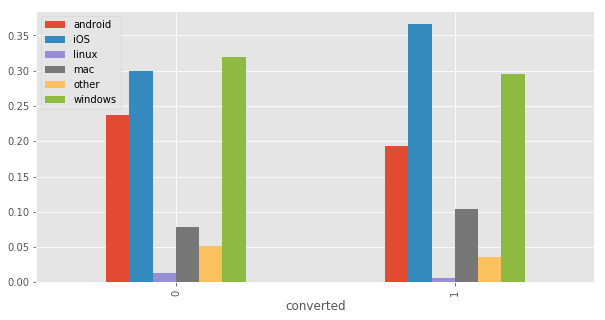

In [22]:
os_by_converted.plot(kind='bar',figsize=(10,5))

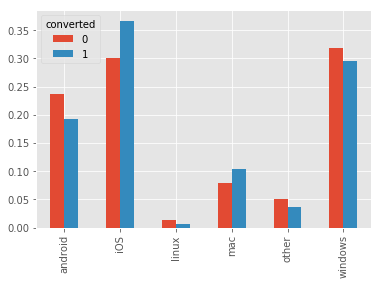

In [23]:
os_by_converted.transpose().plot(kind='bar')

## Model 
Ici on va construire ici un arbre de régression afin de vizualiser l'importance des variables explicatives. 

In [24]:
testdata.sample(10)# glance the data

,timestamp,source,device,OS,test,price,converted
user_id,,,,,,,
829599,2015-04-25 11:25:05,ads-google,web,windows,1,59,0
967072,2015-05-06 09:30:04,seo-google,mobile,iOS,0,39,0
85716,2015-04-10 01:14:02,seo-google,mobile,android,0,39,0
502382,2015-04-12 18:25:54,ads_facebook,web,windows,1,59,0
274320,2015-04-20 18:03:11,seo_facebook,web,windows,1,59,0
430304,2015-04-09 01:53:35,seo_facebook,web,windows,0,39,0
661998,2015-04-11 18:08:52,ads_other,mobile,iOS,0,39,0
798555,2015-03-28 11:60:47,ads_facebook,mobile,android,1,59,0
188392,2015-03-13 15:59:13,ads-bing,web,windows,1,59,0


In [25]:
X = testdata.copy()
del X['timestamp']
del X['test']

In [26]:
X.source.value_counts()

direct_traffic     60357
ads-google         59379
ads_facebook       53396
ads_other          29876
seo-google         23175
ads-bing           22873
seo_facebook       21205
friend_referral    20695
seo-other           9260
ads-yahoo           7583
seo-yahoo           6848
seo-bing            2153
Name: source, dtype: int64

In [27]:
X.device.value_counts()

mobile    186471
web       130329
Name: device, dtype: int64

In [28]:
X.OS.value_counts()

windows    100976
iOS         95465
android     74935
mac         25085
other       16204
linux        4135
Name: OS, dtype: int64

## Encodage 
Gros sujet, commençon avant tout à expliquer la différence entre `LabelEncoder()` et `get_dummies()`. 
Soit une liste de variable tel que,
```
liste = ["Apple", "Ball", "Cat"]
```
l'encodage de cette liste sera :  
```
encoder = [1, 2, 3]
```
alors que la dummies liste sera: 
```
dummy = [001, 010, 100]
```

**Explications** 


D'un côté, `LabelEncoder()` transforme simplement les données, de sorte que son domaine soit $(0, ...,k - 1)$, où $k$ est le nombre de classes.
De l'autre côté, `get_dummies()` prend également une série d'éléments mais la développe dans un DataFrame dont les colonnes correspondent aux entrées de la série et dont les valeurs sont respectivement 0 ou 1, en fonction de ce qu’elles étaient à l’origine. 

**Conclusion**

Le principal avantage de `LabelEncoder()` est la "préservation de l’espace". Inversement, le codage d'éléments sous forme d'entiers peut donner l'impression à votre algorithme que l'ordre des variables signifie quelque chose. "Apple" est-il plus proche de "Cat" que de "Ball" juste à cause du codage entier? probablement pas. La représentation en `get_dummies()` est plus claire à ce sujet.


In [29]:
# One-Hot-Encoding on categorical features
X = pd.get_dummies(X)

# a categorical feature of K unique values, only need K-1 vectors
# I don't use 'drop_first' parameter in get_dummies, since it cannot specify which level to drop
del X['source_ads_other']
del X['device_web']
del X['OS_other']

In [30]:
X.tail()# glance the data

,price,converted,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook,device_mobile,OS_android,OS_iOS,OS_linux,OS_mac,OS_windows
user_id,,,,,,,,,,,,,,,,,,,
17427,39,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
687787,39,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
618863,39,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
154636,39,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
832372,59,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0


In [31]:
Xtrain = X.loc[:,X.columns != 'converted']
ytrain = X.loc[:,'converted']

In [32]:
Xtrain.head()# glance the data

,price,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook,device_mobile,OS_android,OS_iOS,OS_linux,OS_mac,OS_windows
user_id,,,,,,,,,,,,,,,,,,
604839,39,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
624057,39,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0
317970,39,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
685636,59,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
820854,39,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


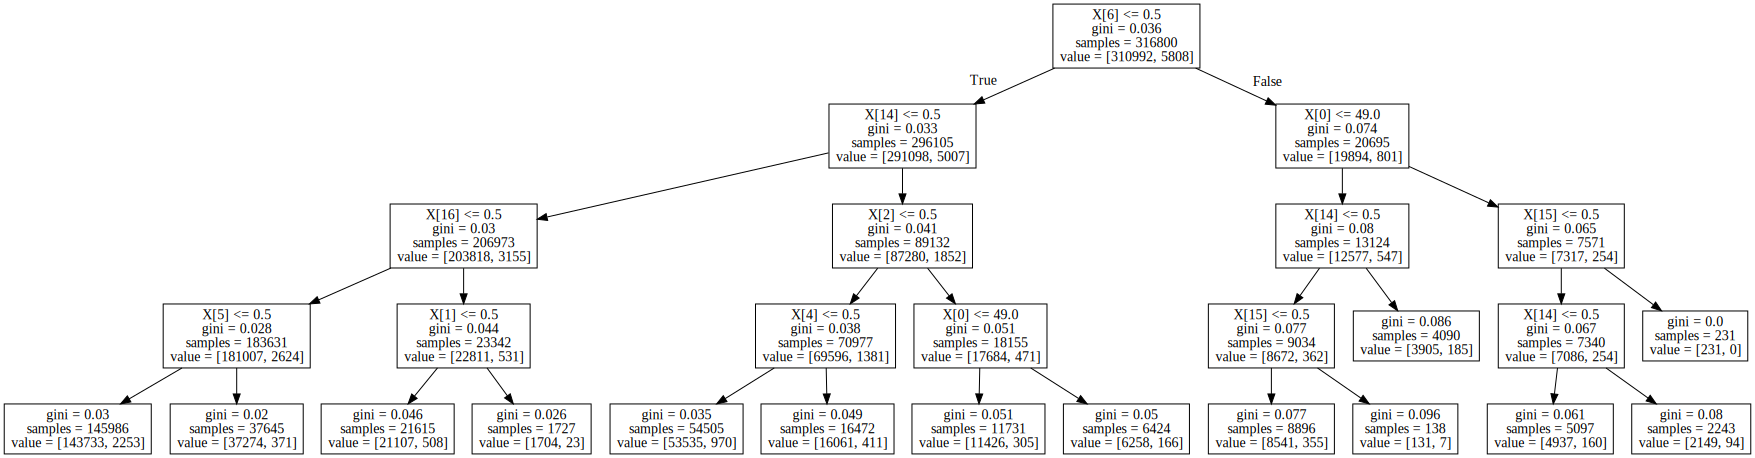

In [39]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=4)
dt.fit(Xtrain,ytrain)
from sklearn import tree
import graphviz
tree1 = tree.export_graphviz(dt, out_file=None)
graph = graphviz.Source(tree1) 
graph

On peut donc retracer le chemin suivant des client les mieux convertis : 
1. **source 'friend_referral' = true**
2. **price < 49, i.e., price = 39**
3. **OS 'iOS'= true**

In [34]:
pd.Series(dt.feature_importances_,index = Xtrain.columns).sort_values(ascending=False)

source_friend_referral    0.582278
OS_iOS                    0.136605
OS_mac                    0.093907
source_direct_traffic     0.059002
source_ads_facebook       0.041034
source_ads-google         0.038543
price                     0.020118
OS_linux                  0.018002
source_ads-bing           0.010511
source_ads-yahoo          0.000000
OS_windows                0.000000
source_seo-bing           0.000000
source_seo-other          0.000000
source_seo-yahoo          0.000000
source_seo_facebook       0.000000
device_mobile             0.000000
OS_android                0.000000
source_seo-google         0.000000
dtype: float64

## Conclusion et perspectives ? 